# Encoder - MVP

Self-supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [1]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.

In [2]:
print_flag = True
reset_kernel = True
check_memory_usage = True
time_flag = True
window_size_percentage = False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [3]:
import utils.config as cfg_
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [4]:
pre_configured_case = True
case_id = 1
frequency_factor = 5
frequency_factor_change_alias = True

## Main code
### Import libraries

In [5]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_long_term_forecasting_splits, get_forecasting_splits #TODO: Quitar 1 cuando esté decidida la opción
import wandb
if check_memory_usage: 
    import nbs_pipeline.utils.memory as mem

Used mem: 262
Used mem: 24576
Memory Usage: [--------------------] 1%
Used mem: 34337
Used mem: 257575
Memory Usage: [██------------------] 13.3%


### Initialize and Configurate Artifact

In [6]:
wandb_api = wandb.Api()

#### Setup CUDA

In [7]:
cuda_device = 0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

Used mem: 262
Used mem: 24576
Memory Usage: [--------------------] 1%


#### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [9]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP_SWV(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

alias: Monash-Australian_electricity_demand -> solar_4_seconds
time_col is missing in original dict | None 
csv_config is missing in original dict | {} 
w: 30 -> 900
valid_artifact: None
mask_sync: False
r: 0.71
analysis_mode: online
artifact_name is missing in original dict | solar_4_seconds-20s 
mvp_ws: (15, 30) -> [450, 900]
norm_use_by_single_batch is missing in original dict | (False,) 
data_cols is missing in original dict | [] 
freq is missing in original dict | 4s 
batch_size: 512
use_wandb: True
norm_use_single_batch: False
epochs: 100
valid_size: 0.2
mask_future: False
norm_by_sample: False
wandb_group: None
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest -> mi-santamaria/deepvats/solar_4_seconds-20s:latest
resampling_freq is missing in original dict | 20S 
stride: 15 -> 450
mask_stateful: True


### Setup W&B artiffact

In [10]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_MVP-sliding_window_view"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02c_encoder_MVP-sliding_window_view


In [11]:
if print_flag: cfg_.show_attrdict(config)

alias: solar_4_seconds
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [450, 900]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 450
train_artifact: mi-santamaria/deepvats/solar_4_seconds-20s:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 900
wandb_group: None
artifact_name: solar_4_seconds-20s
data_cols: []
freq: 4s
time_col: None
csv_config: {}
resampling_freq: 20S
norm_use_by_single_batch: (False,)


In [12]:
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


### Split data using Sliding Window & Get training artiffact

#### Get W&B train artifact
##### Build artifact selector
Botch to use artifacts offline

In [13]:
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)

alias: solar_4_seconds
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [450, 900]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 450
train_artifact: mi-santamaria/deepvats/solar_4_seconds-20s:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 900
wandb_group: None
artifact_name: solar_4_seconds-20s
data_cols: []
freq: 4s
time_col: None
csv_config: {}
resampling_freq: 20S
norm_use_by_single_batch: [False]


In [14]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

In [15]:
train_artifact = artifacts_gettr(config.train_artifact)

In [16]:
df_train = train_artifact.to_df()
if print_flag:
    print(df_train.shape)
    display(df_train.head)

wandb:   1 of 1 files downloaded.  


(1479445, 1)


<bound method NDFrame.head of                        0
2019-08-01 00:00:03  0.0
2019-08-01 00:00:23  0.0
2019-08-01 00:00:43  0.0
2019-08-01 00:01:03  0.0
2019-08-01 00:01:23  0.0
...                  ...
2020-07-08 11:06:43  0.0
2020-07-08 11:07:03  0.0
2020-07-08 11:07:23  0.0
2020-07-08 11:07:43  0.0
2020-07-08 11:08:03  0.0

[1479445 rows x 1 columns]>

### Get training set
Use `prepare_forecasting_data` from tsai. Must take into account it uses the following variables:
> | Variable         | Definition                                           | Default Value | Value Utilised   |
> |------------------|------------------------------------------------------|---------------|------------------|
> | `df`             | Time series DataFrame.                               | -             | `df_train`       |
> | `fcst_history`   | Input historical steps. Window size.                 | -             | `config.w`       |
> | `fcst_horizon`   | Future predicted steps.                              | `1`           | - (no forecasts) |
> | `x_vars`         | Input variables.                                     | `None`        | - (all columns)  |
> | `y_vars`         | Output variables.                                    | `None`        | -                |
> | `dtype`          | Output datatype (for example, `'float32'`).          | `None`        | -                |
> | `unique_id_cols` | None or unique identifier column id.                 | -             | -                |
> 
> For more information, visit [tsai - data - preparation - prepare_forecasting_data](https://timeseriesai.github.io/tsai/data.preparation.html#prepare_forecasting_data)recasting_data)

In [17]:
if print_flag: 
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)

df_train ~  (1479445, 1)
window_sizes =  [450, 900]
wlen =  900


In [18]:
X_train, _ = prepare_forecasting_data(df_train, fcst_history = config.w)

In [19]:
if print_flag:
    print("X ~", X_train.shape)
    print("stride ~", config.stride)

X ~ (1478545, 1, 900)
stride ~ 450


#### Apply strides
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window
> <span style="color:red"> TODO: Check if it is the same to set fcst_horizon = stride </span>

In [20]:
X_strided = X_train[::config.stride]
X = X_train

- df_train ~ (num_samples, num_vars)
- X_train ~ (num_samples - window_size, num_vars, window_size)
- X_train_strided ~ ((num_samples - window_size)/stride, num_vars, window_size)

In [21]:
print("X ~ ", X.shape)
print("X_strided ~ ", X_strided.shape)

X ~  (1478545, 1, 900)
X_strided ~  (3286, 1, 900)


### Split Training Set into Training and Test Dataset

> Use the `get_forecasting_splits` function from tsai to split your time series data. Understand and adapt the parameters to suit your needs:
>
> | Variable               | Definition                                             | Default Value | Value Utilised     |
> |------------------------|--------------------------------------------------------|---------------|--------------------|
> | `df`                   | DataFrame containing a sorted time series.             | -             | `df_train`         |
> | `fcst_history`         | Number of historical steps used as input.              | -             | `config.w`         |
> | `fcst_horizon`         | Number of steps forecasted into the future.            | `1`           | 1 (no forecasts)   |
> | `stride`               | Strides of the sliding windows (input and target).     | `1`           | `config.stride`    |
> | `valid_size`           | Size of the training set (based on datetimes).         | `0.0`         | `config.valid_size`|
> | `test_size`            | Size of the test set (based on datetimes).             | `0.2`         | `0.2`              |
> | `valid_cutoff_datetime`| First prediction datetime of validation dataset.       | `None`        | -                  |
> | `test_cutoff_datetime` | First prediction datetime of test dataset.             | `None`        | -                  |
> | `datetime_col`         | Column with the datetime values.                       | `None`        | `config.time_col   |
> | `use_index`            | Flag to indicate if datetime is in the index.          | `False`       | `True`             |
> | `unique_id_cols`       | Column/s with the unique identifier/s for each entity. | `None`        | -                  |
> | `show_plot`            | Flag to indicate if splits should be plotted.          | `True`        | `True`             |
>
> For more information, visit [tsai - Splitting data - get_forecasting_splits](https://timeseriesai.github.io/tsai/data.validation.html#get_forecasting_splits).

In [22]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

In [23]:
if config.analysis_mode == 'online': 
    splits = get_forecasting_splits(
        df = df_train, 
        fcst_history = config.w,
        fcst_horizon = 1,
        stride = config.stride, 
        test_size = 0.2,
        show_plot = True
    )
    #    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X_strided)), valid_size=config.valid_size)

if print_flag:
    display(splits)


(array([    294,     744,    1194, ..., 1181994, 1182444, 1182894],
       dtype=int32),
 array([1183344, 1183794, 1184244, 1184694, 1185144, 1185594, 1186044,
        1186494, 1186944, 1187394, 1187844, 1188294, 1188744, 1189194,
        1189644, 1190094, 1190544, 1190994, 1191444, 1191894, 1192344,
        1192794, 1193244, 1193694, 1194144, 1194594, 1195044, 1195494,
        1195944, 1196394, 1196844, 1197294, 1197744, 1198194, 1198644,
        1199094, 1199544, 1199994, 1200444, 1200894, 1201344, 1201794,
        1202244, 1202694, 1203144, 1203594, 1204044, 1204494, 1204944,
        1205394, 1205844, 1206294, 1206744, 1207194, 1207644, 1208094,
        1208544, 1208994, 1209444, 1209894, 1210344, 1210794, 1211244,
        1211694, 1212144, 1212594, 1213044, 1213494, 1213944, 1214394,
        1214844, 1215294, 1215744, 1216194, 1216644, 1217094, 1217544,
        1217994, 1218444, 1218894, 1219344, 1219794, 1220244, 1220694,
        1221144, 1221594, 1222044, 1222494, 1222944, 122339

## MVP - Encoder training
Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [24]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [25]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

(1478545, 1, 900)


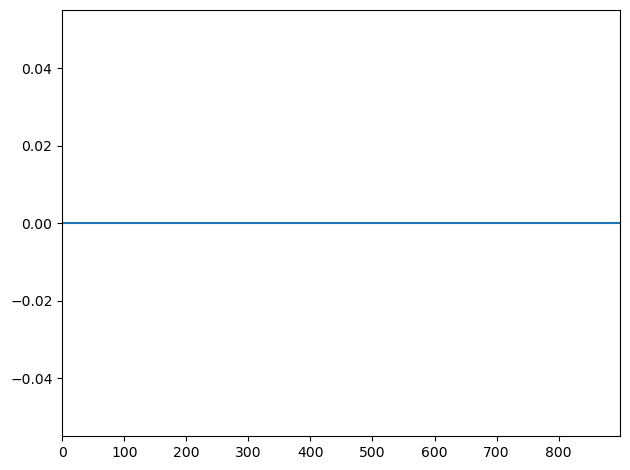

None

In [26]:
if print_flag: print(X.shape)
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
if print_flag: display(dls.show_at(0))

#### Check dls

In [27]:
if print_flag:
    print("X ~", X.shape) 
    print("dls batch size", dls.bs)


X ~ (1478545, 1, 900)
dls batch size 512


#### Build MVP TS Learner

##### Auxiliar functions for ensuring absolute/percentage window size management and checking the result.

In [28]:
if (not window_size_percentage):
    from copy import deepcopy
    def ensure_expected_window_size(expected_window_size, print_flag: bool = False):
        window_size = deepcopy(expected_window_size)
        if print_flag: print(window_size)
        window_size[0] = window_size[0] / window_size[1]
        if print_flag: 
            print(window_size)
            print(int(round(window_size[0]*window_size[1])))
        return window_size
    def check_expected_window_size(learn, expected_window_size, print_flag: bool = False):
        # Find MVP calback
        obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
        if print_flag: print("obtained percentage", obtained_window_size)
        obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
        if print_flag: print("obtained absolute", obtained_window_size)
        return obtained_window_size == expected_window_size

In [29]:
if not window_size_percentage:
    window_size = ensure_expected_window_size(config.mvp_ws)
else:
    window_size = config.mvp_ws
window_size

[0.5, 900]

##### Initialize learner

In [30]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, 
                   InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                       window_size=window_size, 
                       future_mask = config.mask_future, 
                       target_dir='./models', 
                       sync = config.mask_sync, 
                       stateful = config.mask_stateful,
                       fname=f'encoder_MVP',
                       verbose=False
                    ), y_range=[X.min(), X.max()])

#### Check learner

In [31]:
if not window_size_percentage:
    check_expected_window_size(learn, config.mvp_ws, print_flag = print_flag)
    if print_flag:
        print("learn dls.bs",  learn.dls.bs)

obtained percentage [0.5, 900]
obtained absolute [450, 900]
learn dls.bs 512


#### Example mask

##### Create mask

In [32]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

##### Show mask

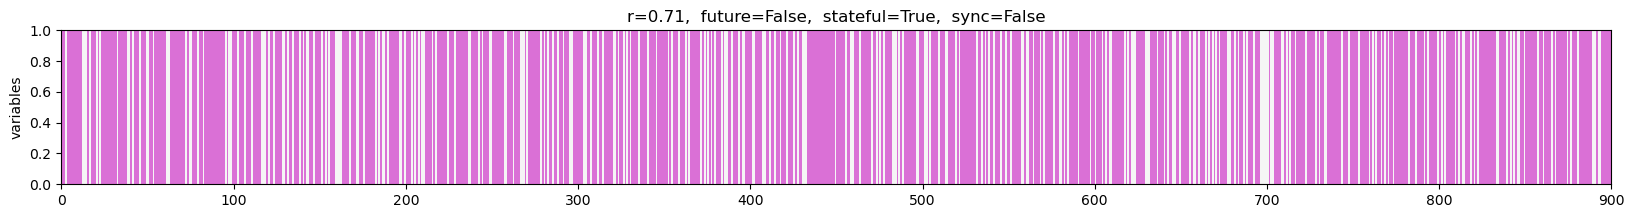

In [33]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 #### Check window size configuration

##### Check config attributes

In [34]:
expected_window_size = config.mvp_ws
if print_flag:
    print("w", config.w, "mvp_ws", config.mvp_ws)
    print("expected ", expected_window_size)
    print(*config.mvp_ws)
np.random.randint(*config.mvp_ws)

w 900 mvp_ws [450, 900]
expected  [450, 900]
450 900


671

In [35]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if print_flag: print("obtained ", obtained_window_size)
obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
if print_flag: print("obtained ", obtained_window_size)

obtained  [0.5, 900]
obtained  [450, 900]


In [36]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


##### Check w1 < w2 for MVP random window size selection

In [37]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    print(obtained_window_size)
    ws = np.random.randint(*obtained_window_size)
    print(ws)

[450, 900]
497


### Train the model

In [38]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if print_flag: print("obtained ", obtained_window_size)

obtained  [0.5, 900]


In [39]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 428
Used mem: 24576
Memory Usage: [--------------------] 2%


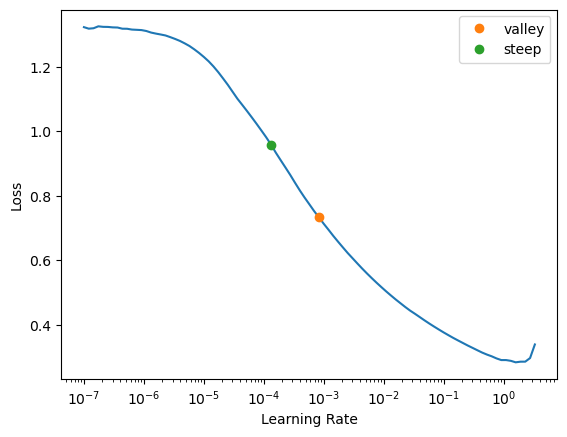

In [40]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

In [41]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if print_flag: print("obtained ", obtained_window_size)

obtained  [450, 900]


In [42]:
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, print_flag=True):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [450, 900]
obtained absolute [405000, 900]
[450, 900]
[0.5, 900]
450


In [43]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 20298
Used mem: 24576
Memory Usage: [████████████████----] 83%


epoch     train_loss  valid_loss  time    
0         0.492830    0.677966    00:00     


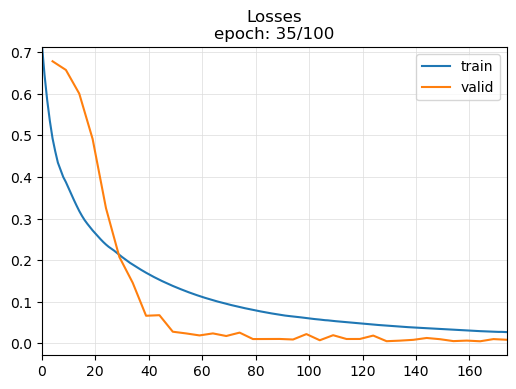

1         0.387520    0.657131    00:00     
2         0.318102    0.600155    00:00     
3         0.271510    0.491221    00:00     
4         0.237534    0.324986    00:00     
5         0.212613    0.207739    00:00     
6         0.189430    0.145680    00:00     
7         0.169804    0.066389    00:00     
8         0.152820    0.067765    00:00     
9         0.138088    0.028052    00:00     
10        0.125161    0.023935    00:00     
11        0.113720    0.019132    00:00     
12        0.103887    0.023986    00:00     
13        0.095166    0.017720    00:00     
14        0.087367    0.025881    00:00     
15        0.080447    0.010397    00:00     
16        0.074295    0.010523    00:00     
17        0.068862    0.010645    00:00     
18        0.064692    0.009347    00:00     
19        0.060801    0.022330    00:00     
20        0.057241    0.007527    00:00     
21        0.053933    0.019652    00:00     
22        0.050889    0.010547    00:00     
23        

In [ ]:
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

In [ ]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

#### Validate the model

In [ ]:
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, print_flag=True):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

In [ ]:
learn.validate()

## Visualize predictions

In [ ]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [ ]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

In [ ]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp-SWV', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [ ]:
run.finish()

In [ ]:
print("Execution ended")
beep(1)
if reset_kernel:
    import os
    os._exit(00)